# 数据预处理

In [1]:
#导入torch部分
import torch
import torch
torch.manual_seed(1)
from torch.nn import Linear
from torch.autograd import Variable
import torch.nn as nn

import os
os.chdir("/home/zhangjingxiao/yxk/autoencoder/Retina")
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist
#from keras import regularizers
from sklearn.preprocessing import scale
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,_kl_divergence)
from time import time
import numpy as np
# import keras
# import keras.backend as K
# from keras.engine.topology import Layer, InputSpec
# from keras.layers import Dense, Input
# from keras.models import Model
# from keras.optimizers import SGD
# from keras import callbacks
# from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
#import pydot
from IPython.display import Image
#from keras.utils import plot_model
from sklearn.metrics import accuracy_score
import sklearn.metrics
import matplotlib.pyplot as plt
import os
os.environ['PYTHONHASHSEED'] = '0'
import pandas as pd
import numpy as np
import scanpy.api as sc
from scipy.sparse import issparse
from time import time
import scipy.io
#from keras.utils.vis_utils import plot_model
#from evaluate import evaluate_scores#自己写的模块
import pickle
# import keras.layers as KL
# from keras import layers
# from keras.layers import Input
# from keras.layers import Lambda
# from keras.models import Model
# from keras.models import Sequential
from sklearn.utils import shuffle
#from keras.losses import mean_squared_error #导入这个
#import tensorflow as tf
import pandas as pd
import numpy as np
import umap
import warnings
warnings.filterwarnings("ignore")
# import tensorflow as tf;
# from keras.utils.vis_utils import plot_model
# import keras
# import pydotplus
# import pydot
# from keras.utils.vis_utils import model_to_dot
# keras.utils.vis_utils.pydot = pydot

/home/zhangjingxiao/.conda/envs/py36/lib/python3.6/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
def creatadata(datadir):
    print("Start reading expression data (matrix.mtx)")
    #setp1-1 read matrix
    mtx=sc.read_mtx(os.path.join(datadir,"matrix.mtx"))
    print("Start reading cell information (barcodes.tsv), may including cellname, celltype....")
    #step1-2 cell information
    cell_info=pd.read_csv(os.path.join(datadir,"barcodes.tsv"),sep="\t",header=0,na_filter=False)    #or header=None
    #step1-3 gene information
    print("Start reading gene information (genes.tsv), including genename,geneid,....")
    gene_info=pd.read_csv(os.path.join(datadir,"genes.tsv"),sep="\t",header=0,na_filter=False)
    #step 1-4 create anndata
    adata=sc.AnnData(mtx.X.transpose(),obs=cell_info,var=gene_info)
    del mtx
    adata.obs_names=adata.obs['cellname'].values
    adata.var_names=adata.var['genename'].values
    adata.obs_names_make_unique(join="-") #Makes the elements of a character vector unique by appending "-" to duplicates.
    adata.obs_names_make_unique(join="-") #Makes the elements of a character vector unique by appending "-" to duplicates.
    adata.var_names_make_unique(join="-") #Makes the elements of a character vector unique by appending "-" to duplicates.
    adata.var_names_make_unique(join="-") #Makes the elements of a character vector unique by appending "-" to duplicates.
    #adata.obs['dataset_label']=dataset
    return adata,adata.obs,adata.var

#read data
x=time()
adata,_,_=creatadata(datadir="/home/zhangjingxiao/yxk/autoencoder/Retina")
print("time of reading data is ",time()-x)

# preprocess
#normalize data
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)
sc.pp.filter_genes(adata,min_cells=1)
sc.pp.filter_genes_dispersion(adata,n_top_genes =1000) #top 1000 gene
#log1p data
sc.pp.log1p(adata)
#sc.pp.scale(adata)

#直接按两个batch做
maprule = {'Bipolar1':'bt1','Bipolar2':'bt1','Bipolar3':'bt1','Bipolar4':'bt1',
'Bipolar5':'bt2','Bipolar6':'bt2'}
adata.obs['BatchIDnew'] = adata.obs.BatchID.map(maprule)

#batch1,adata1 n_obs*n_vars=12364*1000
adata1=adata[adata.obs['BatchID'].isin(['Bipolar1','Bipolar2','Bipolar3','Bipolar4'])].copy()
sc.pp.scale(adata1)#
#batch2,adata2,n_obs*n_vars=11130*1000
adata2=adata[adata.obs['BatchID'].isin(['Bipolar5','Bipolar6'])].copy()
sc.pp.scale(adata2)

adata_con=sc.AnnData.concatenate(adata1,adata2)
sc.pp.scale(adata)

Start reading expression data (matrix.mtx)


Transforming to str index.
Transforming to str index.


Start reading cell information (barcodes.tsv), may including cellname, celltype....
Start reading gene information (genes.tsv), including genename,geneid,....
time of reading data is  41.986406326293945


         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'celltype' as categorical
... storing 'celltype_com' as categorical
... storing 'BatchID' as categorical
... storing 'BatchIDnew' as categorical


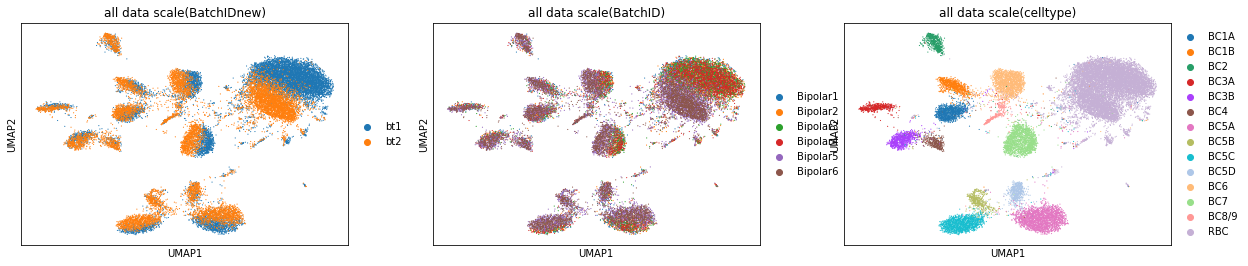

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'BatchID' as categorical
... storing 'BatchIDnew' as categorical
... storing 'celltype' as categorical
... storing 'celltype_com' as categorical


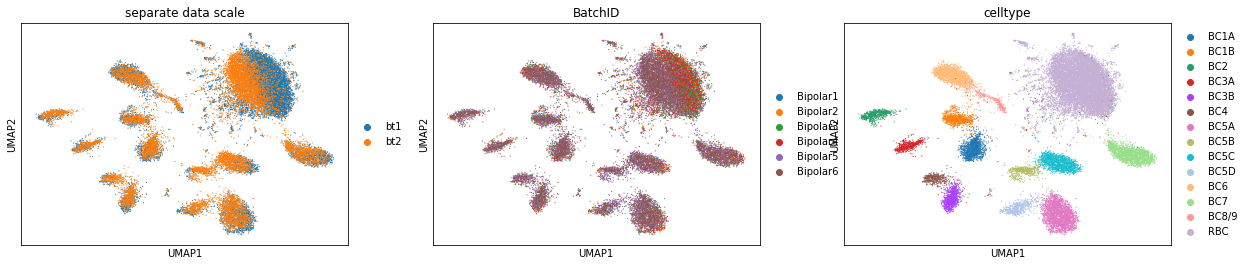

In [3]:

#全部数据进行统一scale，可视化
sc.pp.neighbors(adata,n_neighbors=15,random_state=0)
sc.tl.umap(adata)
sc.pl.umap(adata,color=['BatchIDnew','BatchID','celltype'],title=["all data scale(BatchIDnew)","all data scale(BatchID)","all data scale(celltype)"])

#分别的batch进行scale，再合并，进行可视化
sc.pp.neighbors(adata_con,n_neighbors=15,random_state=0)
sc.tl.umap(adata_con)
sc.pl.umap(adata_con,color=['BatchIDnew','BatchID','celltype'],title="separate data scale")

# 参数设置

In [56]:
num_batch=2
labda=9
batch_size=100
num_iter=1000
base = 1.0
sigma_list = [1, 2, 4]
sigma_list = [sigma / base for sigma in sigma_list]

# 网络结构 
$lambda=9$

$loss=lambda*resconstructionLoss+mmdLoss()$


In [57]:
#!/usr/bin/env python
import torch.nn as nn
import torch
import torch.onnx
import netron

def init_weights(m):
    """ initialize weights of fully connected layer,权重和偏置初始化的方式和keras的方式不一样
    """
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

# autoencoder with hidden units 20, 2, 20
# Encoder
class Encoder(nn.Module):
    def __init__(self, num_inputs):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_inputs, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256,32))
        self.encoder.apply(init_weights)
    def forward(self, x):
        x = self.encoder(x)
        return x
# Decoder
class Decoder(nn.Module):
    def __init__(self, num_inputs):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, num_inputs))
        self.decoder.apply(init_weights)#此处init_weights是一个函数
    def forward(self, x):
        x = self.decoder(x)
        return x
# Autoencoder
class autoencoder(nn.Module):
    def __init__(self, num_inputs):
        super(autoencoder, self).__init__()
        self.encoder = Encoder(num_inputs)
        self.decoder = Decoder(num_inputs)
    def forward(self, x):
        code = self.encoder(x)
        x = self.decoder(code)
        return self.encoder.encoder[0].weight,self.decoder.decoder[2].weight,code,x  #注意看这个地方哈，这个地方把中间层得结果直接返回了，就不用自己取了

model=autoencoder(1000)
print(model)
x=torch.rand(1,1000)
m=model(x)
onnx_path = "Retina_model.onnx"
torch.onnx.export(model,x,onnx_path)
netron.start(onnx_path)
#print(model.state_dict())
#print(model.encoder.encoder[0].weight.shape)
#print(model.decoder.decoder[2].weight.shape)

autoencoder(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=1000, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=256, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=32, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=1000, bias=True)
    )
  )
)

Stopping http://localhost:8080
Serving 'Retina_model.onnx' at http://localhost:8080


# mmd_loss

In [58]:

import torch

min_var_est = 1e-8


# Consider linear time MMD with a linear kernel:
# K(f(x), f(y)) = f(x)^Tf(y)
# h(z_i, z_j) = k(x_i, x_j) + k(y_i, y_j) - k(x_i, y_j) - k(x_j, y_i)
#             = [f(x_i) - f(y_i)]^T[f(x_j) - f(y_j)]
#
# f_of_X: batch_size * k
# f_of_Y: batch_size * k
def linear_mmd2(f_of_X, f_of_Y):
    loss = 0.0
    delta = f_of_X - f_of_Y
    loss = torch.mean((delta[:-1] * delta[1:]).sum(1))
    return loss


# Consider linear time MMD with a polynomial kernel:
# K(f(x), f(y)) = (alpha*f(x)^Tf(y) + c)^d
# f_of_X: batch_size * k
# f_of_Y: batch_size * k
def poly_mmd2(f_of_X, f_of_Y, d=2, alpha=1.0, c=2.0):
    K_XX = (alpha * (f_of_X[:-1] * f_of_X[1:]).sum(1) + c)
    K_XX_mean = torch.mean(K_XX.pow(d))

    K_YY = (alpha * (f_of_Y[:-1] * f_of_Y[1:]).sum(1) + c)
    K_YY_mean = torch.mean(K_YY.pow(d))

    K_XY = (alpha * (f_of_X[:-1] * f_of_Y[1:]).sum(1) + c)
    K_XY_mean = torch.mean(K_XY.pow(d))

    K_YX = (alpha * (f_of_Y[:-1] * f_of_X[1:]).sum(1) + c)
    K_YX_mean = torch.mean(K_YX.pow(d))

    return K_XX_mean + K_YY_mean - K_XY_mean - K_YX_mean


def _mix_rbf_kernel(X, Y, sigma_list):
    assert(X.size(0) == Y.size(0))
    m = X.size(0)

    Z = torch.cat((X, Y), 0)
    ZZT = torch.mm(Z, Z.t())
    diag_ZZT = torch.diag(ZZT).unsqueeze(1)
    Z_norm_sqr = diag_ZZT.expand_as(ZZT)
    exponent = Z_norm_sqr - 2 * ZZT + Z_norm_sqr.t()

    K = 0.0
    for sigma in sigma_list:
        gamma = 1.0 / (2 * sigma**2)
        K += torch.exp(-gamma * exponent)

    return K[:m, :m], K[:m, m:], K[m:, m:], len(sigma_list)


def mix_rbf_mmd2(X, Y, sigma_list, biased=True):
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
    # return _mmd2(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)
    return _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)


def mix_rbf_mmd2_and_ratio(X, Y, sigma_list, biased=True):
    K_XX, K_XY, K_YY, d = _mix_rbf_kernel(X, Y, sigma_list)
    # return _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=d, biased=biased)
    return _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=False, biased=biased)


################################################################################
# Helper functions to compute variances based on kernel matrices
################################################################################


def _mmd2(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)    # assume X, Y are same shape

    # Get the various sums of kernels that we'll use
    # Kts drop the diagonal, but we don't need to compute them explicitly
    if const_diagonal is not False:
        diag_X = diag_Y = const_diagonal
        sum_diag_X = sum_diag_Y = m * const_diagonal
    else:
        diag_X = torch.diag(K_XX)                       # (m,)
        diag_Y = torch.diag(K_YY)                       # (m,)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0)                     # K_{XY}^T * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()                       # e^T * K_{XY} * e

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * K_XY_sum / (m * m))
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))
            + Kt_YY_sum / (m * (m - 1))
            - 2.0 * K_XY_sum / (m * m))

    return mmd2


def _mmd2_and_ratio(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    mmd2, var_est = _mmd2_and_variance(K_XX, K_XY, K_YY, const_diagonal=const_diagonal, biased=biased)
    loss = mmd2 / torch.sqrt(torch.clamp(var_est, min=min_var_est))
    return loss, mmd2, var_est


def _mmd2_and_variance(K_XX, K_XY, K_YY, const_diagonal=False, biased=False):
    m = K_XX.size(0)    # assume X, Y are same shape

    # Get the various sums of kernels that we'll use
    # Kts drop the diagonal, but we don't need to compute them explicitly
    if const_diagonal is not False:
        diag_X = diag_Y = const_diagonal
        sum_diag_X = sum_diag_Y = m * const_diagonal
        sum_diag2_X = sum_diag2_Y = m * const_diagonal**2
    else:
        diag_X = torch.diag(K_XX)                       # (m,)
        diag_Y = torch.diag(K_YY)                       # (m,)
        sum_diag_X = torch.sum(diag_X)
        sum_diag_Y = torch.sum(diag_Y)
        sum_diag2_X = diag_X.dot(diag_X)
        sum_diag2_Y = diag_Y.dot(diag_Y)

    Kt_XX_sums = K_XX.sum(dim=1) - diag_X             # \tilde{K}_XX * e = K_XX * e - diag_X
    Kt_YY_sums = K_YY.sum(dim=1) - diag_Y             # \tilde{K}_YY * e = K_YY * e - diag_Y
    K_XY_sums_0 = K_XY.sum(dim=0)                     # K_{XY}^T * e
    K_XY_sums_1 = K_XY.sum(dim=1)                     # K_{XY} * e

    Kt_XX_sum = Kt_XX_sums.sum()                       # e^T * \tilde{K}_XX * e
    Kt_YY_sum = Kt_YY_sums.sum()                       # e^T * \tilde{K}_YY * e
    K_XY_sum = K_XY_sums_0.sum()                       # e^T * K_{XY} * e

    Kt_XX_2_sum = (K_XX ** 2).sum() - sum_diag2_X      # \| \tilde{K}_XX \|_F^2
    Kt_YY_2_sum = (K_YY ** 2).sum() - sum_diag2_Y      # \| \tilde{K}_YY \|_F^2
    K_XY_2_sum  = (K_XY ** 2).sum()                    # \| K_{XY} \|_F^2

    if biased:
        mmd2 = ((Kt_XX_sum + sum_diag_X) / (m * m)
            + (Kt_YY_sum + sum_diag_Y) / (m * m)
            - 2.0 * K_XY_sum / (m * m))
    else:
        mmd2 = (Kt_XX_sum / (m * (m - 1))
            + Kt_YY_sum / (m * (m - 1))
            - 2.0 * K_XY_sum / (m * m))

    var_est = (
        2.0 / (m**2 * (m - 1.0)**2) * (2 * Kt_XX_sums.dot(Kt_XX_sums) - Kt_XX_2_sum + 2 * Kt_YY_sums.dot(Kt_YY_sums) - Kt_YY_2_sum)
        - (4.0*m - 6.0) / (m**3 * (m - 1.0)**3) * (Kt_XX_sum**2 + Kt_YY_sum**2)
        + 4.0*(m - 2.0) / (m**3 * (m - 1.0)**2) * (K_XY_sums_1.dot(K_XY_sums_1) + K_XY_sums_0.dot(K_XY_sums_0))
        - 4.0*(m - 3.0) / (m**3 * (m - 1.0)**2) * (K_XY_2_sum) - (8 * m - 12) / (m**5 * (m - 1)) * K_XY_sum**2
        + 8.0 / (m**3 * (m - 1.0)) * (
            1.0 / m * (Kt_XX_sum + Kt_YY_sum) * K_XY_sum
            - Kt_XX_sums.dot(K_XY_sums_1)
            - Kt_YY_sums.dot(K_XY_sums_0))
        )
    return mmd2, var_est

# training 先与Retina-2-batch-修改

labda= 9
num_iter_time= 1000
num_batch= 2
sigma_list= [1.0, 2.0, 4.0]
batch_size= 100
total_loss= 17.85965347290039
total_loss= 16.969249725341797
total_loss= 16.493732452392578
total_loss= 16.635009765625
total_loss= 15.773965835571289
total_loss= 16.62640380859375
total_loss= 16.789043426513672
total_loss= 15.668231010437012
total_loss= 14.897886276245117
total_loss= 14.886497497558594
total_loss= 14.684039115905762
total_loss= 14.240635871887207
total_loss= 15.285602569580078
total_loss= 13.895484924316406
total_loss= 13.78776741027832
total_loss= 13.510055541992188
total_loss= 13.731801986694336
total_loss= 13.200827598571777
total_loss= 13.158378601074219
total_loss= 14.627622604370117
total_loss= 12.903536796569824
total_loss= 12.039939880371094
total_loss= 12.38595199584961
total_loss= 12.746238708496094
total_loss= 11.436342239379883
total_loss= 12.520198822021484
total_loss= 11.710613250732422
total_loss= 11.899633407592773
total_loss= 11.84130573272705
total_loss= 11.67563056

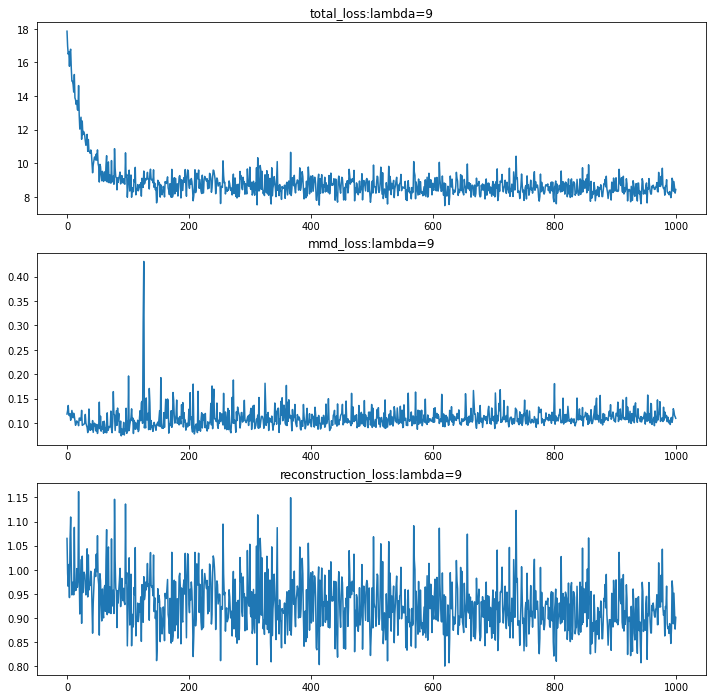

In [59]:
print("labda=",labda)
print("num_iter_time=",num_iter)
print("num_batch=",num_batch)
print("sigma_list=",sigma_list)
print("batch_size=",batch_size)
import numpy as np
import torch
import torch.utils.data #数据加载与预处理
from torch.autograd import Variable
import torch.nn.functional as F #后面有用到F.mseloss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999))
#optimizer=torch.optim.Adam(model.parameters(),lr=0.001,betas=(0.9,0.999))
logs=np.array([])
mmd=np.array([])
recons=np.array([])
model.train()#会开启batch_normazation的形式
for i in range(num_iter):

    optimizer.zero_grad() #更新一次
    index1= np.random.choice(len(adata1),batch_size)# 
    index2= np.random.choice(len(adata2),batch_size)#
#     index3= np.random.choice(len(adata3),batch_size)
#     index4= np.random.choice(len(adata4),batch_size)
#     index5= np.random.choice(len(adata5),batch_size)
#     index6= np.random.choice(len(adata6),batch_size)
#    data_batch=np.concatenate((adata1.X[index1,:],adata2.X[index2,:],adata3.X[index3,:],adata4.X[index4,:],adata5.X[index5,:],adata6.X[index6,:]))
    data_batch=np.concatenate((adata1.X[index1,:],adata2.X[index2,:]))
    input=Variable(torch.tensor(data_batch))
    w1,w2,encode_data,output=model(input)
    split_data=encode_data.chunk(num_batch,dim=0)
    mmd_loss=0;
    for i in split_data:
        for j in split_data:
            mmd_loss+= mix_rbf_mmd2(i,j,sigma_list)
    mmd_loss=mmd_loss*2/(num_batch*(num_batch-1))
    recons_loss=F.mse_loss(input, output)
    regular1=0.01*torch.square(torch.norm(w1))#L2正则化是需要torch.norm()的平方，开始写成了regular1=0.01*torch.norm(w1),发现效果不对
    regular2=0.01*torch.square(torch.norm(w2))
    loss=regular1+regular2+mmd_loss+labda*recons_loss
    loss.backward()
    optimizer.step()
    print("total_loss=",loss.data.item())
    #print("mmd_loss=",mmd_loss.data.item())
    #print("recons_loss=",recons_loss.data.item())
    logs=np.append(logs,loss.data.item())
    mmd=np.append(mmd,mmd_loss.data.item())
    recons=np.append(recons,recons_loss.data.item())
#训练损失图
x=np.arange(0,num_iter)
plt.figure(figsize=(12,12))
plt.subplot(311)
plt.plot(x,logs)
plt.title("total_loss:lambda="+str(labda))
plt.subplot(312)
plt.plot(x,mmd)
plt.title("mmd_loss:lambda="+str(labda))
plt.subplot(313)
plt.plot(x,recons)
plt.title("reconstruction_loss:lambda="+str(labda))
plt.show()

# 中间层可视化

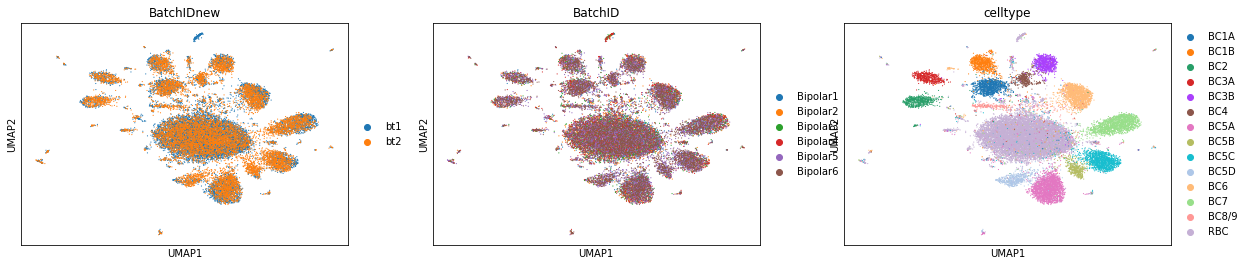

In [60]:
model.eval()
#中间层UMAP可视化
_,_,encode_data,_=model(torch.tensor(adata_con.X))
encode_data=sc.AnnData(encode_data.data.numpy(),obs=adata_con.obs) 
sc.pp.neighbors(encode_data,n_neighbors=15,random_state=0)
sc.tl.umap(encode_data)
sc.pl.umap(encode_data,color=['BatchIDnew','BatchID','celltype'])
# print(type(encode_data))
# print(encode_data.size())
# print(encode_data.data.numpy())

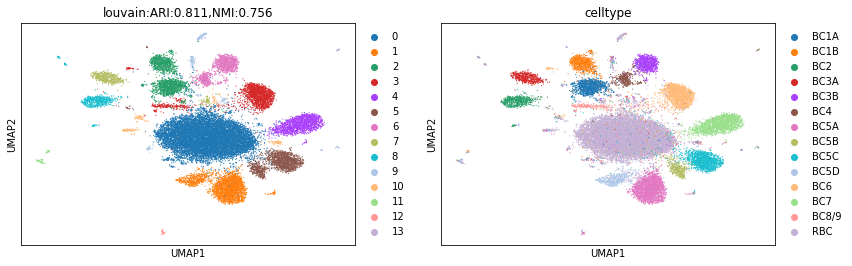

In [61]:
def find_resolution(adata_, n_clusters, random): 
    adata = adata_.copy()
    obtained_clusters = -1
    iteration = 0
    resolutions = [0., 1000.]
    while obtained_clusters != n_clusters and iteration < 50:
        current_res = sum(resolutions)/2
        sc.tl.louvain(adata, resolution = current_res, random_state = random)
        labels = adata.obs['louvain']
        obtained_clusters = len(np.unique(labels))
        
        if obtained_clusters < n_clusters:
            resolutions[0] = current_res
        else:
            resolutions[1] = current_res
        iteration = iteration + 1
    return current_res
reso=find_resolution(encode_data,14,0)
sc.tl.louvain(encode_data,resolution=reso,random_state=0)
from sklearn.metrics.cluster import adjusted_rand_score,normalized_mutual_info_score
ARI= adjusted_rand_score(encode_data.obs["celltype"], encode_data.obs["louvain"])
NMI= normalized_mutual_info_score(encode_data.obs["celltype"], encode_data.obs["louvain"])
sc.pl.umap(encode_data,color=["louvain","celltype"],title=["louvain:"+"ARI:"+str(round(ARI,3))+",NMI:"+str(round(NMI,3)),"celltype"])

# DataLoader()

In [44]:
# import numpy as np
# import torch
# from torch.utils.data import Dataset, DataLoader
# #定义Mydataset继承自Dataset,并重写__getitem__和__len__,Dataset是基类
# class Mydataset(Dataset):
#     def __init__(self, num_batch):
#         super(Mydataset, self).__init__()
#         self.num = num #生成多少个点（多少个数据）

#         self.x_train = np.linspace(0, 50, num=self.num) #从0-50生成num多个点
#         self.y_train = linear_f(self.x_train)
#         self.x_train = torch.Tensor(self.x_train)#转化为张量
#         self.y_train = torch.Tensor(self.y_train)
#     # indexing
#     def __getitem__(self, index):
#         return self.x_train[index], self.y_train[index]
#     #返回数据集大小，应该是（x_transpose,y_transpose）大小即num*2，这里我直接返回了num
#     def __len__(self):
#         return self.num
# from torch.autograd import Variable
# iter_times=500;
# for i in range(iter_times):
#     index1= np.random.choice(len(adata1),batch_size)# XJ: 改成adata1.shape[0]
#     index2= np.random.choice(len(adata2),batch_size)#
# #     index3= np.random.choice(len(adata3),batch_size)
# #     index4= np.random.choice(len(adata4),batch_size)
# #     index5= np.random.choice(len(adata5),batch_size)
# #     index6= np.random.choice(len(adata6),batch_size)
# #    data_batch=np.concatenate((adata1.X[index1,:],adata2.X[index2,:],adata3.X[index3,:],adata4.X[index4,:],adata5.X[index5,:],adata6.X[index6,:]))
#     data_batch=np.concatenate((adata1.X[index1,:],adata2.X[index2,:]))
#     input=Variable(data_batch)
#     recons